[View in Colaboratory](https://colab.research.google.com/github/SalmaAhmed95/Twitter-Sentiment-Classification-Using-Distant-Supervision/blob/master/TwitterSentimentAnalysis.ipynb)

In [1]:
# This cell connects to google drive, authenticates connection, and iterates over file list displaying each file's title and ID.
# it also imports and installs all the necessary libraries
!pip install -U -q PyDrive
!pip install -U -q wordcloud
!pip install -U -q bokeh
!pip install textblob

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from bs4 import BeautifulSoup

from wordcloud import WordCloud
from scipy.stats import hmean
from scipy.stats import norm
from pylab import *
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
from bokeh.models import HoverTool

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from textblob import TextBlob
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from time import time

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_list = drive.ListFile(
    {'q': "'1UHoxe2J0_QVgWD1P4BdF94CVALiHn3S5' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


title: TwitterSentimentAnalysis.ipynb, id: 1A9doDERyDk5qz9Hy0LykCXeQdqKvmlMn
title: ArabicTwitterSentimentAnalysis.ipynb, id: 1vFKIwtlbsyjjA2Q8kPw3SzQ8sjYsXxbZ
title: clean_Arabic_Tweets_1600000Tweet.csv, id: 1fRMY2iwapHLnXE3jlRjveeg2Ihz-aD6h
title: clean_Arabic_Tweets_1600000Tweet.csv, id: 1aaHKTwFJDnlw-TJuK4whN_fLn0isLvfv
title: ArabicTweetsNonClean.csv, id: 1TNaUswMaVMhkWTEdNpeRBVwbizi6uKyZ
title: data3.zip, id: 1Ppsec65-wQ7eZpKWJLPmj_HPyj2EEhNF
title: positive.zip, id: 1VAMxTC7UAyk-fBRXCmQZ5T75w62zdhL4
title: Twitter Sentiment Analysis report, id: 1LKyzCRnL3Y6Bila7iQgcBuMO8V279NHKfSgCBa_Xa0E
title: clean_Tweets_1600000Tweet.csv, id: 1bFJu26UFNgkYU0u0hANXAfvfz3-L-2Ry
title: clean_Tweets_1.6millionTweet.csv, id: 1auKc_BBHVk-FQJkOIyLrlCS-ivRW3fIx
title: training.1600000.processed.noemoticon.csv, id: 1XdARv07vjTvdAPHgwFrMobo-ivCaO8U-
title: Arabic Dataset Collection, id: 1sBc-KW9HQ6pf5C9u-jiSYTt6CvkQP9Kl00GQOMmlvc0
title: Research Implementation plan, id: 1DSyAZ2xmklZEys_xtWf1x_YUUj6WQ

In [0]:
training_data = drive.CreateFile({'id': '1XdARv07vjTvdAPHgwFrMobo-ivCaO8U-'})
training_data.GetContentFile('training.1600000.processed.noemoticon.csv')  

# upload file into pandas dataframe and drop unnecessary columns and neutral rows

cols = ['sentiment','id','date','query_string','user','text']
df_train = pd.read_csv('training.1600000.processed.noemoticon.csv',header=None, usecols = [0,5],names=cols, encoding='latin-1')
clean_tweets = []   
# drop rows with neutral sentiment 
df_train.drop(df_train[df_train.sentiment == 2].index, inplace=True)
# drop rows with retweet text 
df_train.drop(df_train[df_train.text.str.contains(' RT ')].index, inplace=True)

df_train

In [0]:
#data preprocessing
chunks_range = [0,400000,800000,1200000,1600000] 
for i in range(chunks_range[3],chunks_range[4]):   #repeat for all range
  clean_tweets.append(clean(df_train['text'][i]))
  


,Unnamed: 0,text,target
0,0,"- aww, that's a bummer. you shoulda got dav...",0
1,1,is upset that he can't update his facebook by ...,0
2,2,i dived many times for the ball. managed to s...,0
3,3,my whole body feels itchy and like its on fire,0
4,4,"no, it's not behaving at all. i'm mad. why am...",0
5,5,not the whole crew,0
6,6,need a hug,0
7,7,"hey long time no see! yes.. rains a bit ,onl...",0
8,8,nope they didn't have it,0
9,9,que me muera ?,0


In [0]:
#save to csv file
clean_df = pd.DataFrame(clean_tweets, columns=['text'])
clean_df['target'] = df_train.sentiment

clean_df.to_csv('clean_Tweets_1600000Tweet.csv',encoding='utf-8')

file = drive.CreateFile({'parents':[{u'id': '1UHoxe2J0_QVgWD1P4BdF94CVALiHn3S5'}]})
file.SetContentFile("clean_Tweets_1600000Tweet.csv")
file.Upload()

In [0]:
#Strips emojis
def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :'),:D, : D, =)
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))|:\s?D | =\)', '', tweet)
    # Sad -- :-(, : (, :(, ):, )-: , :p
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)|:p', '', tweet)
    return tweet
  

In [0]:
#clean data
url = re.compile(r"(?:(http[s]?://\S+)|((//)?(\w+\.)?\w+\.\w+/\S+))")
user_mention = re.compile(r"(?:(?<!\w)@\w+\b)")
number = re.compile(r"(?:\b\d+\b)")
repeated_char = '([a-zA-Z])\\1+'
length_repeated_char = '\\1\\1'

def clean(raw):
  #convert HTML encoding to text
  new_row = BeautifulSoup(raw, 'html.parser').get_text()
  
  #Change all text to lower case
  new_row = new_row.lower()
  
  #Replaces any url with class URL
  new_row = re.sub(url, '', new_row)
  
  #replace any @username with class USERNAME
  new_row = re.sub(user_mention, '', new_row)
  
  #Strips repeated chars
  new_row = re.sub(repeated_char, length_repeated_char, new_row)
  
  #Replaces #hashtag with hashtag
  new_row = re.sub(r'#(\S+)', r' \1 ', new_row)
  
  #Remove numbers
  new_row = re.sub(number, '', new_row)
  
  #decode text with 'utf-8-sig'
  try:
    temp_row = new_row.decode("utf-8-sig").replace(u"\ufffd", "?")     
  except:
    temp_row = new_row
  
  #Removes emojis
  new_row = handle_emojis(temp_row);
  
  return new_row

In [2]:
# Reading clean data from drive and saving it locally in memory
clean_data = drive.CreateFile({'id': '1bFJu26UFNgkYU0u0hANXAfvfz3-L-2Ry'})
clean_data.GetContentFile('clean_Tweets_1600000Tweet')  

# upload file into pandas dataframe and drop unnecessary columns and neutral rows

# Using columns 1,2 because col 0 is the number of the row, could be changed if the row number is removed from the csv file.
df_clean = pd.read_csv('clean_Tweets_1600000Tweet', usecols = [1,2], encoding='latin-1')

df_clean

,text,target
0,"- aww, that's a bummer. you shoulda got dav...",0
1,is upset that he can't update his facebook by ...,0
2,i dived many times for the ball. managed to s...,0
3,my whole body feels itchy and like its on fire,0
4,"no, it's not behaving at all. i'm mad. why am...",0
5,not the whole crew,0
6,need a hug,0
7,"hey long time no see! yes.. rains a bit ,onl...",0
8,nope they didn't have it,0
9,que me muera ?,0


In [3]:
# Checking read cleaned file info if there are any null entries (found none) or white space
df_clean.info()
df_clean['text'] = df_clean['text'].str.strip()
df_clean.drop(df_clean[df_clean.text == ''].index, inplace=True)
df_clean

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
text      1600000 non-null object
target    1600000 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


,text,target
0,"- aww, that's a bummer. you shoulda got david...",0
1,is upset that he can't update his facebook by ...,0
2,i dived many times for the ball. managed to sa...,0
3,my whole body feels itchy and like its on fire,0
4,"no, it's not behaving at all. i'm mad. why am ...",0
5,not the whole crew,0
6,need a hug,0
7,"hey long time no see! yes.. rains a bit ,only...",0
8,nope they didn't have it,0
9,que me muera ?,0


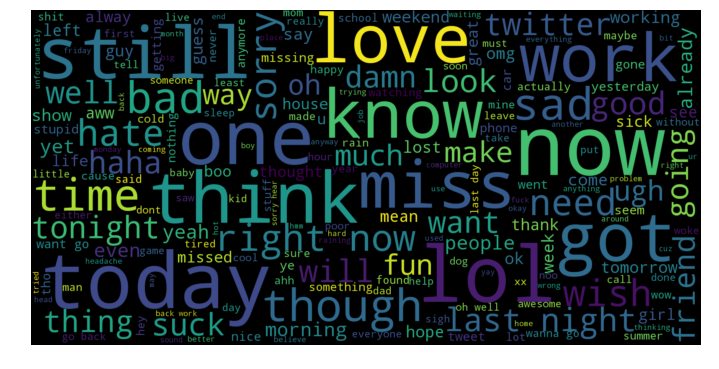

In [0]:
# Visualizing negative tweets in a word cloud format
neg_tweets = df_clean[df_clean.target == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()



In [0]:
# Observing some of the negative tweets that contain the word "love"
for t in neg_tweets.text[:200]:
    if 'love' in t:
        print (t)

ahh ive always wanted to see rent  love the soundtrack!!
meh... almost lover is the exception... this track gets me depressed every time.
awe i love you too!!!!  am here  i miss you
damn! the grind is inspirational and saddening at the same time.  don't want you to stop cuz i like what u do! much love
i'm missing you babe..  but as long as your alive i'm happy.. yawwnn.. i'm tired my love imma try to sleep hopefully you had a headstart
love the french. i tell people here in the south i'm qtr. french and they snarl at me.  french are beautiful people


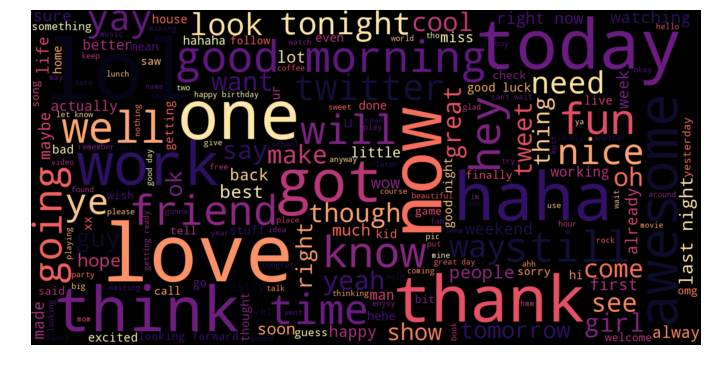

In [0]:
# Visualizing positive tweets in a word cloud format
pos_tweets = df_clean[df_clean.target == 4]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
    
pos_string = pd.Series(pos_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string)
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

In [0]:
# Using CountVectorizer library to analyze frequency of words in tweets
cvec = CountVectorizer()
cvec.fit(df_clean.text)

len(cvec.get_feature_names()) # outputs total number of words


263017

In [0]:
# Building term frequency table to observe the most frequent words in the dataset, notice that all of them are stop words.
neg_doc_matrix = cvec.transform(df_clean[df_clean.target == 0].text)
pos_doc_matrix = cvec.transform(df_clean[df_clean.target == 4].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df.head()

term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
to,313132,252526,565658
the,257833,265966,523799
my,190836,125964,316800
it,157204,147496,304700
and,153965,149629,303594
you,103841,198187,302028
is,128016,108919,236935
in,115433,101080,216513
for,98982,117361,216343
of,92716,91082,183798


Text(0.5,1,'Top 500 tokens in tweets')

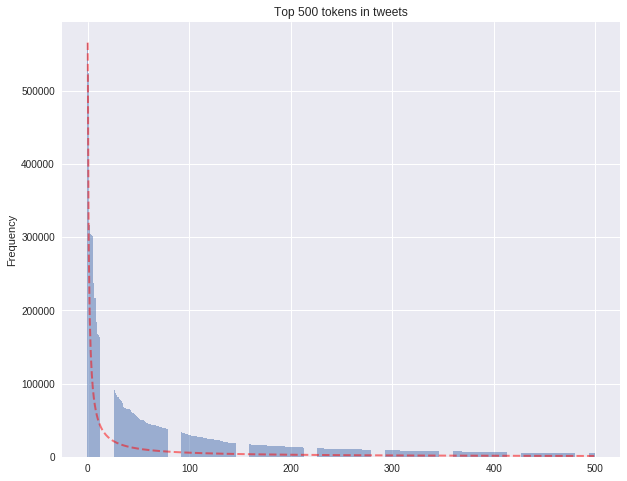

In [0]:
# Plotting tokens' frequency to see if they follow zipf's law( which states that the frequecy of the rth word => f(r) is directly prop with 1 / r)
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets')

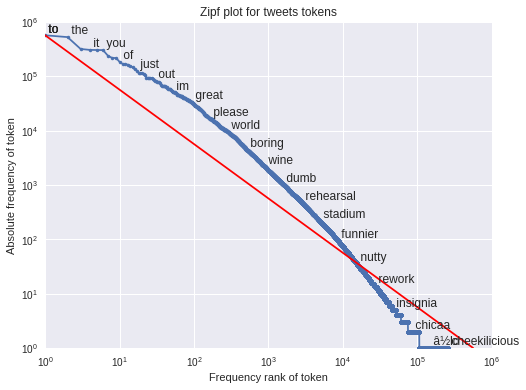

In [0]:
# Using a log-log graph, like the last one, near zipfian should be a straight line, we notice in more frequent words, their freq is above expected zipfian, and less freuent is below near zipfian
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

In [0]:
# Now we want to see what are the most frequent words in positive and negative tweets seperately.
cvec = CountVectorizer(stop_words='english',max_features=10000) # Removing stop words this time and limiting studied words to 10k
cvec.fit(df_clean.text)
document_matrix = cvec.transform(df_clean.text)


In [0]:
df_clean[df_clean.target == 4]

,text,target
800000,i love u guys r the best!!,4
800001,im meeting up with one of my besties tonight! ...,4
800002,"thanks for the twitter add, sunisa! i got to m...",4
800003,being sick can be really cheap when it hurts t...,4
800004,he has that effect on everyone,4
800005,you can tell him that i just burst out laughin...,4
800006,thans for your response. ihad already find thi...,4
800007,"i am so jealous, hope you had a great time in ...",4
800008,"ah, congrats mr fletcher for finally joining t...",4
800009,i responded stupid cat is helping me type. fo...,4


In [0]:
# Processing negative tweets
%%time
neg_batches = np.linspace(0,798491,10).astype(int)
i=0
neg_tf = []
while i < len(neg_batches)-1:
    batch_result = np.sum(document_matrix[neg_batches[i]:neg_batches[i+1]].toarray(),axis=0)
    neg_tf.append(batch_result)
    print (neg_batches[i+1],"entries' term freuquency calculated")
    i += 1

88721 entries' term freuquency calculated
177442 entries' term freuquency calculated
266163 entries' term freuquency calculated
354884 entries' term freuquency calculated
443606 entries' term freuquency calculated
532327 entries' term freuquency calculated
621048 entries' term freuquency calculated
709769 entries' term freuquency calculated
798491 entries' term freuquency calculated
CPU times: user 24.8 s, sys: 5.39 s, total: 30.2 s
Wall time: 30.2 s


In [0]:
# Processing positive tweets
%%time
pos_batches = np.linspace(800000,1599999,10).astype(int)
i=0
pos_tf = []
while i < len(pos_batches)-1:
    batch_result = np.sum(document_matrix[pos_batches[i]:pos_batches[i+1]].toarray(),axis=0)
    pos_tf.append(batch_result)
    print (pos_batches[i+1],"entries' term freuquency calculated")
    i += 1

888888 entries' term freuquency calculated
977777 entries' term freuquency calculated
1066666 entries' term freuquency calculated
1155555 entries' term freuquency calculated
1244443 entries' term freuquency calculated
1333332 entries' term freuquency calculated
1422221 entries' term freuquency calculated
1511110 entries' term freuquency calculated


IndexError: ignored

In [0]:
# Displaying the top frequent words(non-stop) in both positive and negative tweets
neg = np.sum(neg_tf,axis=0)
pos = np.sum(pos_tf,axis=0)
term_freq_df2 = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df2.columns = ['negative', 'positive']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
term_freq_df2.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
just,64013,55820,119833
good,29554,56387,85941
day,39856,41674,81530
like,41046,33429,74475
today,38114,26597,64711
work,45402,16955,62357
going,33684,27637,61321
love,16989,42532,59521
got,33288,24850,58138
lol,23136,32323,55459


Text(0.5,1,'Top 50 tokens in negative tweets')

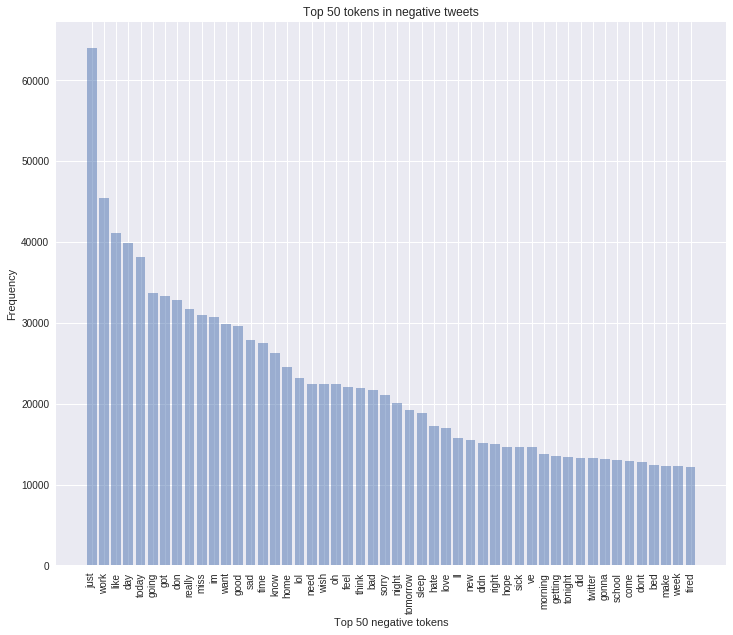

In [0]:
# Displaying most common words in negative tweets
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets')



Text(0.5,1,'Top 50 tokens in positive tweets')

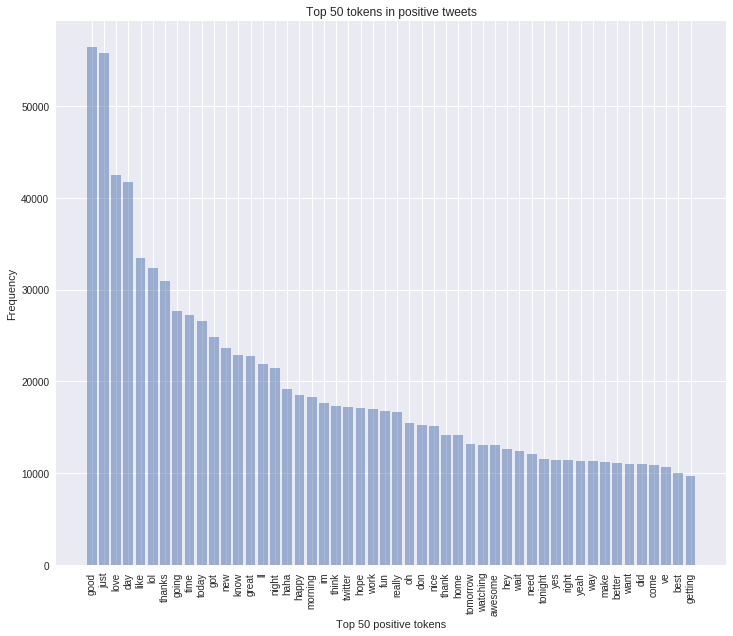

In [0]:
# Displaying most common words in positive tweets
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets')

Text(0.5,1,'Negative Frequency vs Positive Frequency')

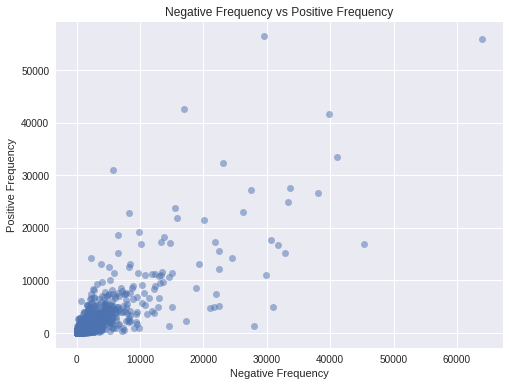

In [0]:
# We noticed in the above many neutral words occuring in both classes, let's plot the negative frequency of a word on X-axis, and the positive frequency on Y-axis
plt.figure(figsize=(8,6))
ax = sns.regplot(x="negative", y="positive",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

In [0]:
# As we can't infer much meaning from the previous plots, let's define a pos_rate and neg_rate, to indicate the rate of freq of a word in a certain class vs the other class
term_freq_df2['pos_rate'] = term_freq_df2['positive'] * 1./term_freq_df2['total']
term_freq_df2.sort_values(by='pos_rate', ascending=False).iloc[:10]

,negative,positive,total,pos_rate
m2e,0,79,79,1.000000
mileymonday,0,161,161,1.000000
emailunlimited,0,100,100,1.000000
tweeterfollow,0,26,26,1.000000
iamsoannoyed,0,246,246,1.000000
dividends,0,83,83,1.000000
tweeteradder,1,830,831,0.998797
shareholder,1,80,81,0.987654
fuzzball,2,86,88,0.977273
recommends,3,107,110,0.972727


In [0]:
# Now let's define a freq_pct representing the rate by which a word occurs in a certain class only
term_freq_df2['pos_freq_pct'] = term_freq_df2['positive'] * 1./term_freq_df2['positive'].sum()
term_freq_df2.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct
good,29554,56387,85941,0.656113,0.014267
just,64013,55820,119833,0.465815,0.014123
love,16989,42532,59521,0.714571,0.010761
day,39856,41674,81530,0.511149,0.010544
like,41046,33429,74475,0.448862,0.008458
lol,23136,32323,55459,0.582827,0.008178
thanks,5801,30942,36743,0.842120,0.007829
going,33684,27637,61321,0.450694,0.006993
time,27512,27191,54703,0.497066,0.006880
today,38114,26597,64711,0.411012,0.006729


In [0]:
term_freq_df2['pos_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']]) if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 else 0), axis=1)               
term_freq_df2.sort_values(by='pos_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean
good,29554,56387,85941,0.656113,0.014267,0.027926
just,64013,55820,119833,0.465815,0.014123,0.027415
love,16989,42532,59521,0.714571,0.010761,0.021203
day,39856,41674,81530,0.511149,0.010544,0.020662
like,41046,33429,74475,0.448862,0.008458,0.016603
lol,23136,32323,55459,0.582827,0.008178,0.016130
thanks,5801,30942,36743,0.842120,0.007829,0.015513
going,33684,27637,61321,0.450694,0.006993,0.013772
time,27512,27191,54703,0.497066,0.006880,0.013572
today,38114,26597,64711,0.411012,0.006729,0.013242


In [0]:
from scipy.stats import norm

def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])

term_freq_df2['pos_freq_pct_normcdf'] = normcdf(term_freq_df2['pos_freq_pct'])

term_freq_df2['pos_normcdf_hmean'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_pct_normcdf']])

term_freq_df2.sort_values(by='pos_normcdf_hmean',ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean
welcome,620,6040,6660,0.906907,0.001528,0.003051,0.996875,0.999420,0.998146
thank,2291,14181,16472,0.860915,0.003588,0.007146,0.992764,1.000000,0.996369
thanks,5801,30942,36743,0.842120,0.007829,0.015513,0.990023,1.000000,0.994987
awesome,3820,13027,16847,0.773253,0.003296,0.006564,0.970917,1.000000,0.985244
glad,2272,7420,9692,0.765580,0.001877,0.003746,0.967571,0.999974,0.983505
follow,2555,8300,10855,0.764625,0.002100,0.004189,0.967133,0.999997,0.983290
enjoy,1640,5357,6997,0.765614,0.001355,0.002706,0.967586,0.997851,0.982485
sweet,1649,5272,6921,0.761740,0.001334,0.002663,0.965780,0.997496,0.981382
hi,2155,6445,8600,0.749419,0.001631,0.003254,0.959479,0.999751,0.979201
yay,3164,9404,12568,0.748250,0.002379,0.004744,0.958835,1.000000,0.978985


In [0]:
term_freq_df2['neg_rate'] = term_freq_df2['negative'] * 1./term_freq_df2['total']

term_freq_df2['neg_freq_pct'] = term_freq_df2['negative'] * 1./term_freq_df2['negative'].sum()

term_freq_df2['neg_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])                                                                if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0                                                                else 0), axis=1)
                                                       
term_freq_df2['neg_rate_normcdf'] = normcdf(term_freq_df2['neg_rate'])

term_freq_df2['neg_freq_pct_normcdf'] = normcdf(term_freq_df2['neg_freq_pct'])

term_freq_df2['neg_normcdf_hmean'] = hmean([term_freq_df2['neg_rate_normcdf'], term_freq_df2['neg_freq_pct_normcdf']])

term_freq_df2.sort_values(by='neg_normcdf_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean,neg_rate,neg_freq_pct,neg_hmean,neg_rate_normcdf,neg_freq_pct_normcdf,neg_normcdf_hmean
sad,27917,1338,29255,0.045736,0.000339,0.000672,0.003710,0.706276,0.007382,0.954264,0.005977,0.011880,0.996290,1.000000,0.998141
hurts,7201,402,7603,0.052874,0.000102,0.000203,0.004238,0.501554,0.008405,0.947126,0.001542,0.003079,0.995762,0.999695,0.997725
sick,14616,1232,15848,0.077739,0.000312,0.000621,0.006639,0.684933,0.013150,0.922261,0.003129,0.006238,0.993361,1.000000,0.996670
poor,7480,645,8125,0.079385,0.000163,0.000326,0.006834,0.557145,0.013502,0.920615,0.001602,0.003198,0.993166,0.999821,0.996483
sucks,9902,871,10773,0.080850,0.000220,0.000440,0.007011,0.607878,0.013863,0.919150,0.002120,0.004230,0.992989,0.999999,0.996482
ugh,9049,873,9922,0.087986,0.000221,0.000441,0.007936,0.608320,0.015668,0.912014,0.001937,0.003867,0.992064,0.999994,0.996013
missing,7298,886,8184,0.108260,0.000224,0.000447,0.011173,0.611191,0.021945,0.891740,0.001563,0.003120,0.988827,0.999746,0.994257
headache,5317,388,5705,0.068011,0.000098,0.000196,0.005584,0.498339,0.011045,0.931989,0.001138,0.002274,0.994416,0.993217,0.993816
hate,17206,2334,19540,0.119447,0.000591,0.001175,0.013410,0.867727,0.026411,0.880553,0.003684,0.007337,0.986590,1.000000,0.993250
miss,30973,5028,36001,0.139663,0.001272,0.002521,0.018440,0.996162,0.036209,0.860337,0.006632,0.013162,0.981560,1.000000,0.990694


Text(0.5,1,'neg_hmean vs pos_hmean')

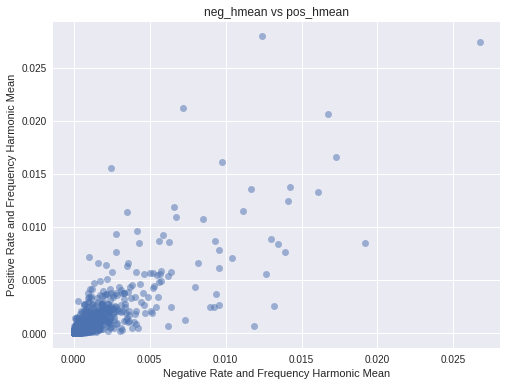

In [0]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_hmean", y="pos_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency Harmonic Mean')
plt.xlabel('Negative Rate and Frequency Harmonic Mean')
plt.title('neg_hmean vs pos_hmean')

Text(0.5,1,'neg_normcdf_hmean vs pos_normcdf_hmean')

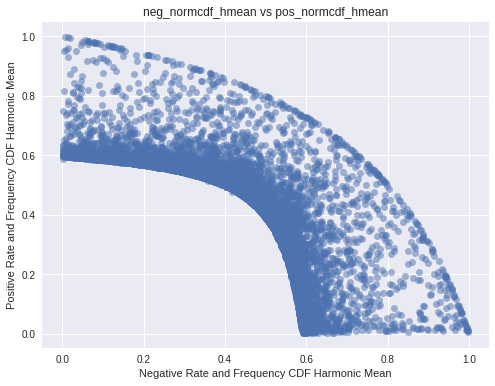

In [0]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_normcdf_hmean", y="pos_normcdf_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_normcdf_hmean vs pos_normcdf_hmean')

In [0]:
output_notebook()
color_mapper = LinearColorMapper(palette='Inferno256', low=min(term_freq_df2.pos_normcdf_hmean), high=max(term_freq_df2.pos_normcdf_hmean))

p = figure(x_axis_label='neg_normcdf_hmean', y_axis_label='pos_normcdf_hmean')

p.circle('neg_normcdf_hmean','pos_normcdf_hmean',size=5,alpha=0.3,source=term_freq_df2,color={'field': 'pos_normcdf_hmean', 'transform': color_mapper})

hover = HoverTool(tooltips=[('token','@index')])
p.add_tools(hover)
show(p)

Loading BokehJS ...

In [4]:
x = df_clean.text
y = df_clean.target

SEED = 2000

#split clean data to two sets : training , validation and test
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
#split the second set into two other sets : validation , test 
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)


print ("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),(len(x_train[y_train == 0]) / (len(x_train)*1.))*100,(len(x_train[y_train == 4]) / (len(x_train)*1.))*100))

print ("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),(len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,(len(x_validation[y_validation == 4]) / (len(x_validation)*1.))*100))

print ("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),(len(x_test[y_test == 0]) / (len(x_test)*1.))*100,(len(x_test[y_test == 4]) / (len(x_test)*1.))*100))




Train set has total 1565232 entries with 49.98% negative, 50.02% positive
Validation set has total 15972 entries with 50.83% negative, 49.17% positive
Test set has total 15972 entries with 50.08% negative, 49.92% positive


In [6]:
print(y_validation)

865431     4
295847     0
126582     0
414532     0
291222     0
562084     0
732511     0
493918     0
1460497    4
1115417    4
613609     0
710126     0
1544222    4
743315     0
1218759    4
141778     0
105217     0
425594     0
1591012    4
894501     4
842562     4
1443012    4
146132     0
619936     0
683984     0
664737     0
1528210    4
1498817    4
1215739    4
267855     0
          ..
1558079    4
271093     0
563586     0
665798     0
544985     0
530029     0
925473     4
1306005    4
132334     0
1005816    4
1453642    4
705052     0
4185       0
331902     0
467240     0
474464     0
354725     0
1233782    4
1055551    4
906817     4
461173     0
422579     0
1356963    4
1364024    4
482892     0
737255     0
645802     0
88356      0
18647      0
98685      0
Name: target, Length: 15972, dtype: int64


In [0]:
# Using Text Blob Python libary for sentiment analysis as baseline for accuracy

tbresult = [TextBlob(i).sentiment.polarity for i in x_validation]
target_names = ['Positive', 'Negative']
tbpred = [0 if n < 0 else 4 for n in tbresult]
conmat = np.array(confusion_matrix(y_validation, tbpred, labels=[4,0]))
confusion = pd.DataFrame(conmat, index=['positive', 'negative'],
                         columns=['predicted_positive','predicted_negative'])

print ("Accuracy Score: {0:.2f}%".format(accuracy_score(y_validation, tbpred)*100))
print ("-"*80)
print ("Confusion Matrix\n")
print (confusion)
print ("-"*80)
# The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. 
# The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

# The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. 
# The recall is intuitively the ability of the classifier to find all the positive samples.

# The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, 
# where an F-beta score reaches its best value at 1 and worst score at 0.
print ("Classification Report\n")
print (classification_report(y_validation, tbpred,target_names=target_names))

Accuracy Score: 60.66%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_positive  predicted_negative
positive                7097                 757
negative                5526                2592
--------------------------------------------------------------------------------
Classification Report

             precision    recall  f1-score   support

   Positive       0.77      0.32      0.45      8118
   Negative       0.56      0.90      0.69      7854

avg / total       0.67      0.61      0.57     15972



In [0]:
def nfeature_accuracy_checker(vectorizer=None, n_features=None, stop_words=None, ngram_range=(1, 1), classifier=None):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

In [0]:
#calculate accuracy for any classifer using {"null accuracy"} and get total time for training and testing
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time


In [0]:
# Using count vectorizer to extract features
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time
cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)


# Unigrams without stop words
print ("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_wosw = nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words='english', classifier=lr)


RESULT FOR UNIGRAM WITHOUT STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 50.83%
accuracy score: 77.80%
model is 26.97% more accurate than null accuracy
train and test time: 61.21s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.83%
accuracy score: 78.06%
model is 27.24% more accurate than null accuracy
train and test time: 70.92s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.83%
accuracy score: 78.10%
model is 27.27% more accurate than null accuracy
train and test time: 95.38s
-------------------------------------------------------

In [0]:
# Unigrams with stop words 
%%time
print ("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug = nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, classifier=lr)

RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 50.83%
accuracy score: 80.50%
model is 29.67% more accurate than null accuracy
train and test time: 148.69s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.83%
accuracy score: 80.60%
model is 29.77% more accurate than null accuracy
train and test time: 146.58s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.83%
accuracy score: 80.65%
model is 29.83% more accurate than null accuracy
train and test time: 221.44s
-------------------------------------------------------

In [0]:
# Testing if the custom stop words match the library defined english stop words
from sklearn.feature_extraction import text

a = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))
b = text.ENGLISH_STOP_WORDS
set(a).issubset(set(b))


True

In [0]:
# Defining custom stop words as top 10 most frequent words in the dataset
my_stop_words = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))

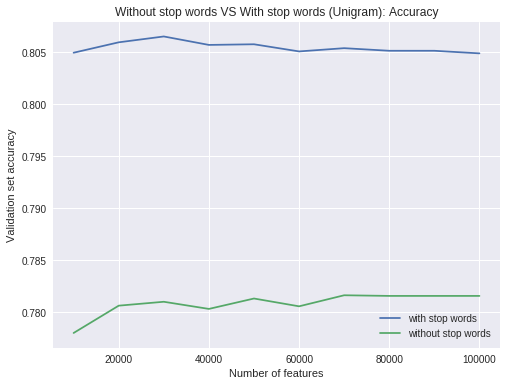

In [0]:
# Plotting the 2 cases of unigrams against each other (with stop words, without stop words)
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wosw = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='with stop words')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

# NOTE: Results showed that training with stop words produces a better accuracy, so bigrams and trigrams will be processed with stop words

In [0]:
# Bigrams
print ("RESULT FOR BIGRAM WITH STOP WORDS\n")
feature_result_bg = nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, ngram_range=(1, 2), classifier=lr)

RESULT FOR BIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 50.83%
accuracy score: 80.73%
model is 29.90% more accurate than null accuracy
train and test time: 212.09s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.83%
accuracy score: 81.43%
model is 30.60% more accurate than null accuracy
train and test time: 242.84s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.83%
accuracy score: 81.69%
model is 30.87% more accurate than null accuracy
train and test time: 244.85s
--------------------------------------------------------

In [0]:
# Triagrams
print ("RESULT FOR TRIGRAM WITH STOP WORDS\n")
feature_result_tg = nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, ngram_range=(1, 3), classifier=lr)


RESULT FOR TRIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 50.83%
accuracy score: 80.75%
model is 29.93% more accurate than null accuracy
train and test time: 365.27s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.83%
accuracy score: 81.29%
model is 30.46% more accurate than null accuracy
train and test time: 391.57s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.83%
accuracy score: 81.73%
model is 30.90% more accurate than null accuracy
train and test time: 505.04s
-------------------------------------------------------

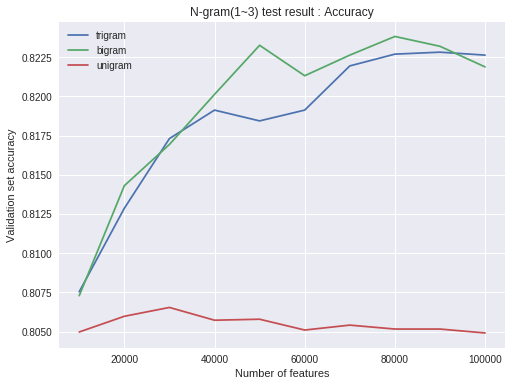

In [0]:
# Plotting Unigrams Vs Biagrams vs Triagrams on the same graph

nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()


In [0]:
#using Tfidf algorithm to extract features
tvec = TfidfVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)





In [0]:
#with stopwords in dataset
feature_result_ugt_sw = nfeature_accuracy_checker(vectorizer=tvec, n_features=n_features, classifier=lr)


In [0]:
#with out stop words in data set
feature_result_ugt_out_sw = nfeature_accuracy_checker(vectorizer=tvec, n_features=n_features, stop_words='english', classifier=lr)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 50.83%
accuracy score: 77.97%
model is 27.15% more accurate than null accuracy
train and test time: 36.58s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.83%
accuracy score: 78.34%
model is 27.52% more accurate than null accuracy
train and test time: 39.62s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.83%
accuracy score: 78.42%
model is 27.59% more accurate than null accuracy
train and test time: 48.56s
--------------------------------------------------------------------------------
Validation re

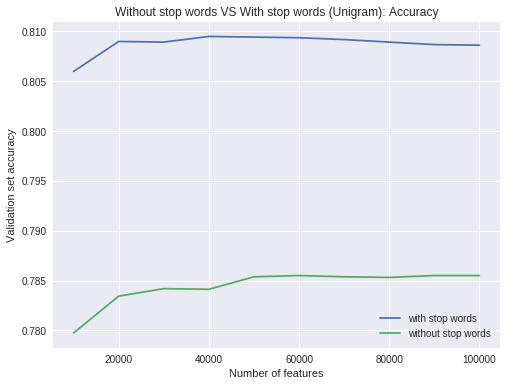

In [0]:
# unigrams against each other (with stop words, with custom stop words, without stop words) In TfIDF
nfeatures_plot_ugt_out_sw = pd.DataFrame(feature_result_ugt_out_sw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt_sw = pd.DataFrame(feature_result_ugt_sw,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ugt_out_sw.nfeatures, nfeatures_plot_ugt_out_sw.validation_accuracy, label='without stop words')
plt.plot(nfeatures_plot_ugt_sw.nfeatures, nfeatures_plot_ugt_sw.validation_accuracy,label='with stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [0]:
feature_result_bgt_sw = nfeature_accuracy_checker(vectorizer=tvec,n_features=n_features, ngram_range=(1, 2), classifier=lr)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 50.83%
accuracy score: 81.12%
model is 30.30% more accurate than null accuracy
train and test time: 119.04s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.83%
accuracy score: 81.56%
model is 30.74% more accurate than null accuracy
train and test time: 127.22s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.83%
accuracy score: 81.97%
model is 31.15% more accurate than null accuracy
train and test time: 139.11s
--------------------------------------------------------------------------------
Validation

In [0]:
feature_result_tgt_sw = nfeature_accuracy_checker(vectorizer=tvec,n_features=n_features, ngram_range=(1, 3), classifier=lr)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Validation result for 10000 features
null accuracy: 50.83%
accuracy score: 81.13%
model is 30.30% more accurate than null accuracy
train and test time: 249.11s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 50.83%
accuracy score: 81.59%
model is 30.77% more accurate than null accuracy
train and test time: 254.82s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 50.83%
accuracy score: 82.00%
model is 31.17% more accurate than null accuracy
train and test time: 266.21s
--------------------------------------------------------------------------------
Validation

In [0]:
feature_result_tgt_sw_3_3 = nfeature_accuracy_checker(vectorizer=tvec,n_features=n_features, ngram_range=(3, 3), classifier=lr)


In [0]:
# Plotting trigram (1,3) features Vs trigram (3,3) features


nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt_sw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_tgt_3_3 = pd.DataFrame(feature_result_tgt_sw_3_3,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram 1-3',color='royalblue')
plt.plot(nfeatures_plot_tgt_3_3.nfeatures, nfeatures_plot_tgt_3_3.validation_accuracy,label='trigram 3-3',linestyle=':', color='royalblue')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [0]:
# Plotting Unigrams Vs Biagrams vs Triagrams on the same graph based on (countvectorizer & tfidf)

nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])

nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt_sw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt_sw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt_sw,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

NameError: ignored

In [0]:
# Trying several classifiers and comparison between them 

from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel

names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf = zip(names,classifiers)

tvec = TfidfVectorizer()

#comparator to compare between accuracy of different zipped classifiers

def classifier_comparator(vectorizer=tvec, n_features=None, stop_words=None, ngram_range=None, classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_accuracy,tt_time))
    return result

trigram_result = classifier_comparator(n_features=100000,ngram_range=(1,3))

In [0]:
#use top 5 of classifiers and use VotingClassifier with voting hard
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = MultinomialNB()
clf4 = RidgeClassifier()
clf5 = PassiveAggressiveClassifier()

eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('mnb', clf3), ('rcs', clf4), ('pac', clf5)], voting='hard')
checker_pipeline = Pipeline([
              ('vectorizer', TfidfVectorizer(max_features=100000,ngram_range=(1, 3))),
              ('classifier', eclf)
])
print ("Validation result for {}".format('Ensemble'))
print (eclf)
accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
